In [1]:
!pip install sdv

zsh:1: command not found: pip


In [2]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'Final Database.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,Unnamed: 0,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL
0,0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,14648.45,1112
1,1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,19124.28,1111
2,2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,19029.51,1110
3,3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,18923.65,1109
4,4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,104171.80,1107


Cycle_Index: This column likely represents the cycle number or index of the battery. Each time a battery goes through a full charge and discharge cycle, this index increments by 1.

Discharge Time (s): The time it takes for the battery to discharge, measured in seconds.

Decrement 3.6-3.4V (s): This could be the time taken for the battery voltage to decrease from 3.6 volts to 3.4 volts during discharge, measured in seconds.

Max. Voltage Dischar. (V): The maximum voltage reached during discharge, measured in volts.

Min. Voltage Charg. (V): The minimum voltage reached during charging, measured in volts.

Time at 4.15V (s): The time it takes for the battery to reach a voltage of 4.15 volts during charging, measured in seconds.

Time constant current (s): This might represent the time constant for the battery during charging, measured in seconds.

Charging time (s): The total time taken for charging the battery, measured in seconds.

Total time (s): The total time of the battery cycle, including both charging and discharging, measured in seconds.

RUL (Remaining Useful Life): This column might represent the remaining useful life of the battery, measured in some unit of time (possibly cycles or seconds). It indicates how much longer the battery is expected to operate effectively before needing replacement or significant maintenance.




# SDV

In [3]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
# Initialize the 'DeviceID' column with zeros
data['DeviceID'] = 1

# Variable to hold the current device ID
current_device_id = 1

# Iterate through the rows to assign device IDs based on the logic described
for i in range(1, len(data)):
    # If the RUL at the current row is higher than the RUL at the previous row,
    # it indicates the start of a new device/cycle
    if data.iloc[i]['RUL'] > data.iloc[i - 1]['RUL']:
        current_device_id += 1
    data.at[data.index[i], 'DeviceID'] = current_device_id
data['DeviceID'][0]= 1
# Now, let's check the first few rows to verify the 'DeviceID' assignment
data.head()


/var/folders/7x/j__wjt4x7kbgynwchj1bdtkm0000gn/T/ipykernel_1409/2193143351.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['DeviceID'][0]= 1


,Unnamed: 0,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL,DeviceID
0,0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,14648.45,1112,1
1,1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,19124.28,1111,1
2,2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,19029.51,1110,1
3,3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,18923.65,1109,1
4,4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,104171.80,1107,1


In [4]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# Assuming 'data' is your DataFrame loaded from the CSV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

# Instantiate the Gaussian Copula Synthesizer with your metadata
synthesizer = GaussianCopulaSynthesizer(
    metadata=metadata, # required
    enforce_min_max_values=True,
    numerical_distributions={
        'Discharge Time (s)': 'beta',
        'Total time (s)': 'uniform'
    },
    default_distribution='norm'
)


# Fit the synthesizer to your dataset
synthesizer.fit(data)

# Generate synthetic data, adjust num_rows as needed
synthetic_data = synthesizer.sample(num_rows=1000000)  # Generates 100 rows of synthetic data
sorted_synthetic_data = synthetic_data.sort_values(by=['DeviceID', 'RUL'], ascending=[True, False])



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sdv/single_table/base.py:80: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [5]:
# Filter rows where Decrement is positive
positive_decrement_df = sorted_synthetic_data[sorted_synthetic_data['Decrement 3.6-3.4V (s)'] > 0]

# Sort by DeviceID, Cycle_Index, and RUL in descending order
sorted_df = positive_decrement_df.sort_values(by=['DeviceID', 'Cycle_Index', 'RUL'], ascending=[True, True, False])

# Group by DeviceID and Cycle_Index and then randomly select one row per group
selected_df = sorted_df.groupby(['DeviceID', 'Cycle_Index']).apply(lambda x: x.sample(1)).reset_index(drop=True)

# Ensure that RUL values are decreasing for each DeviceID
def filter_decreasing_rul(group):
    group = group.sort_values(by='Cycle_Index')
    valid_rows = []
    last_rul = float('inf')
    for index, row in group.iterrows():
        if row['RUL'] < last_rul:
            valid_rows.append(row)
            last_rul = row['RUL']
    return pd.DataFrame(valid_rows)

final_df = selected_df.groupby('DeviceID').apply(filter_decreasing_rul).reset_index(drop=True)

/var/folders/7x/j__wjt4x7kbgynwchj1bdtkm0000gn/T/ipykernel_1409/2580263462.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_df = sorted_df.groupby(['DeviceID', 'Cycle_Index']).apply(lambda x: x.sample(1)).reset_index(drop=True)
/var/folders/7x/j__wjt4x7kbgynwchj1bdtkm0000gn/T/ipykernel_1409/2580263462.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = selected_df.groupby('DeviceID')

In [6]:
final_df.drop(['Unnamed: 0','DeviceID'],axis = 1).to_csv('synthetic_data.csv')

In [7]:
new_data = pd.read_csv('synthetic_data.csv')

new_data.head()

,Unnamed: 0,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL
0,0,1.0,10756.940633,9249.348377,4.076,3.389,12569.637566,30710.530665,23150.336077,717225.820966,1133.0
1,1,2.0,3763.105950,6616.144289,4.000,3.344,7309.680140,9904.157166,5056.186117,153961.554873,1115.0
2,2,3.0,6128.217571,13711.900497,4.025,3.425,9678.459198,12841.436754,14964.972824,470725.227216,1100.0
3,3,7.0,12968.343193,32800.264639,4.092,3.364,17000.589966,22550.219303,26573.512273,739053.009653,1089.0
4,4,16.0,1663.215587,8888.168965,4.050,3.455,-113.584000,14267.120255,5520.662850,611740.881666,1078.0


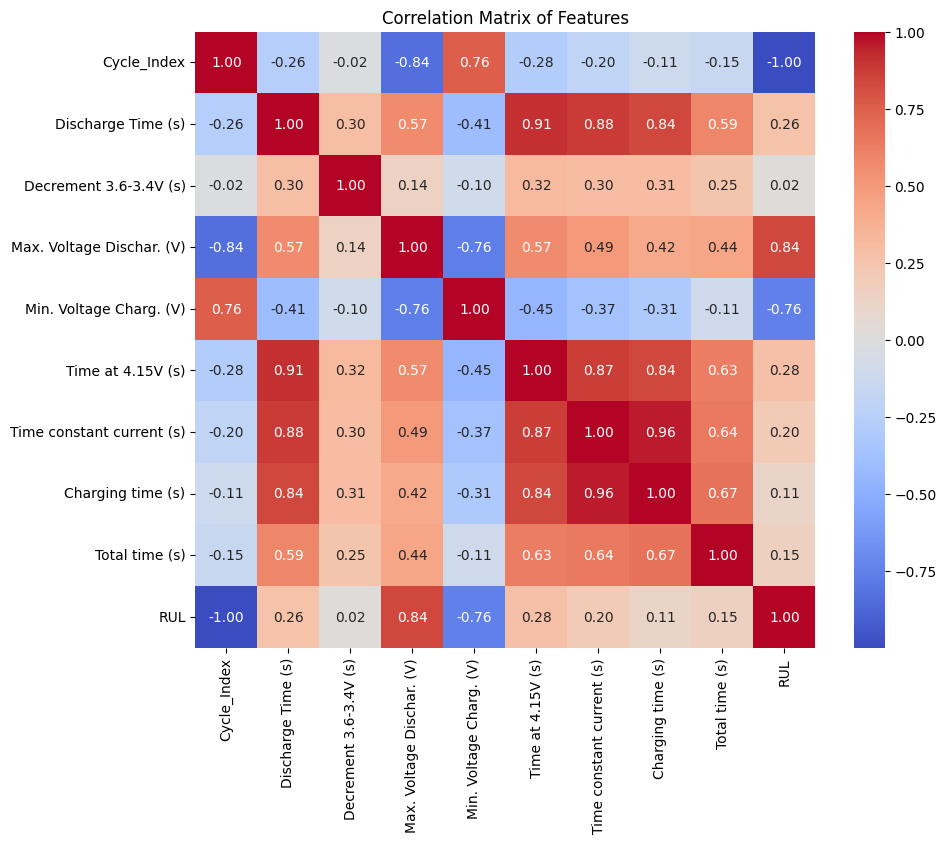

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Assuming 'new_data' is already loaded and is the DataFrame you want to analyze
synthetic_data = new_data

# Calculate and plot the correlation matrix
correlation_matrix = synthetic_data.drop(['Unnamed: 0'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()



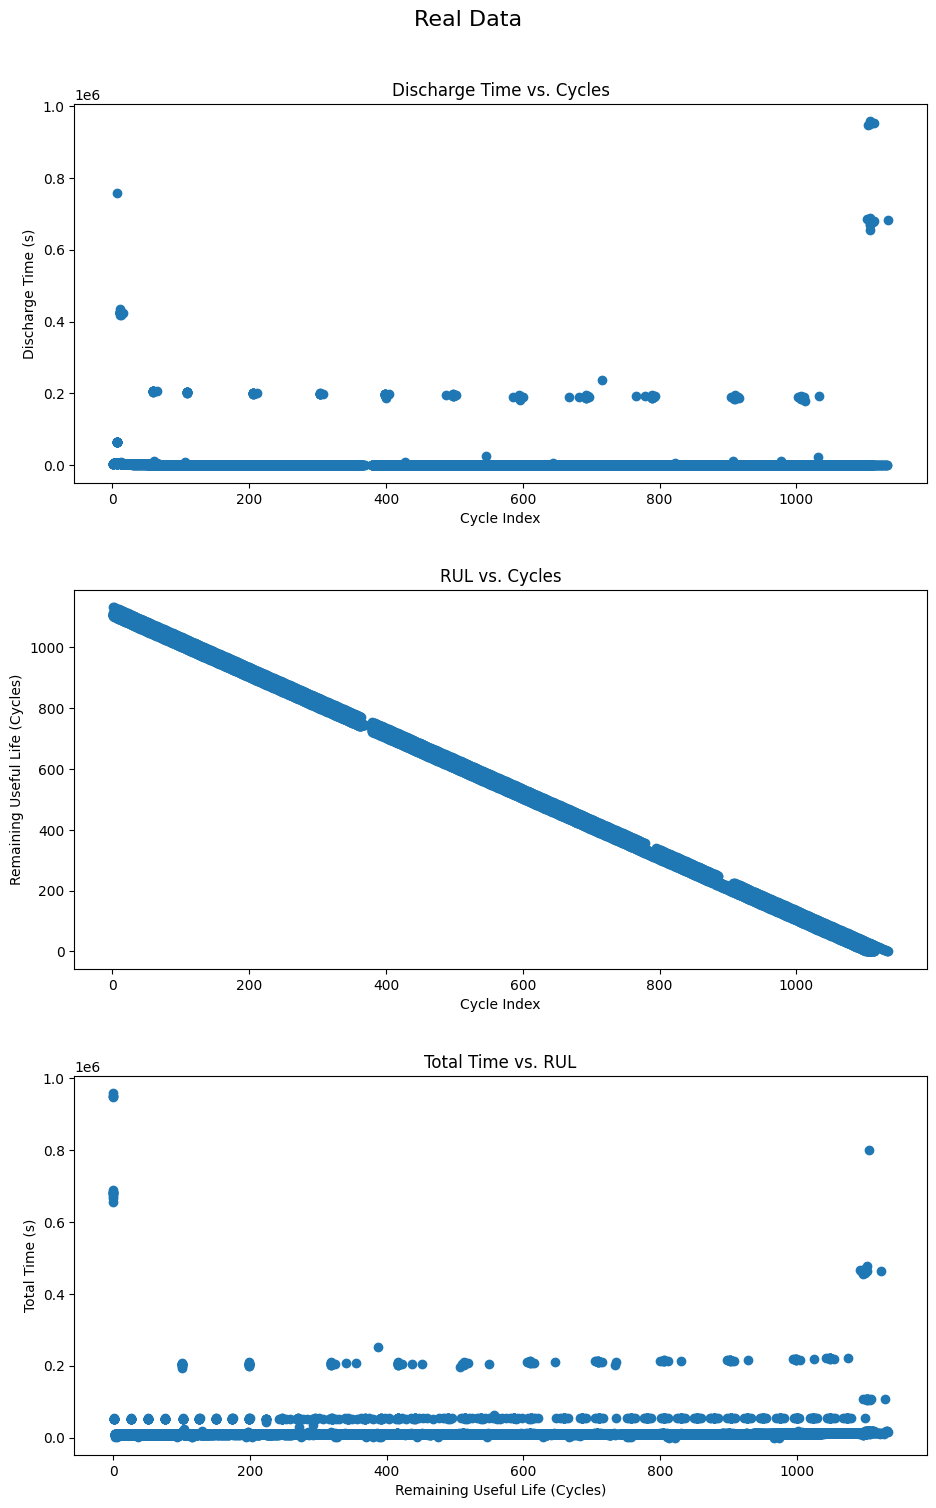

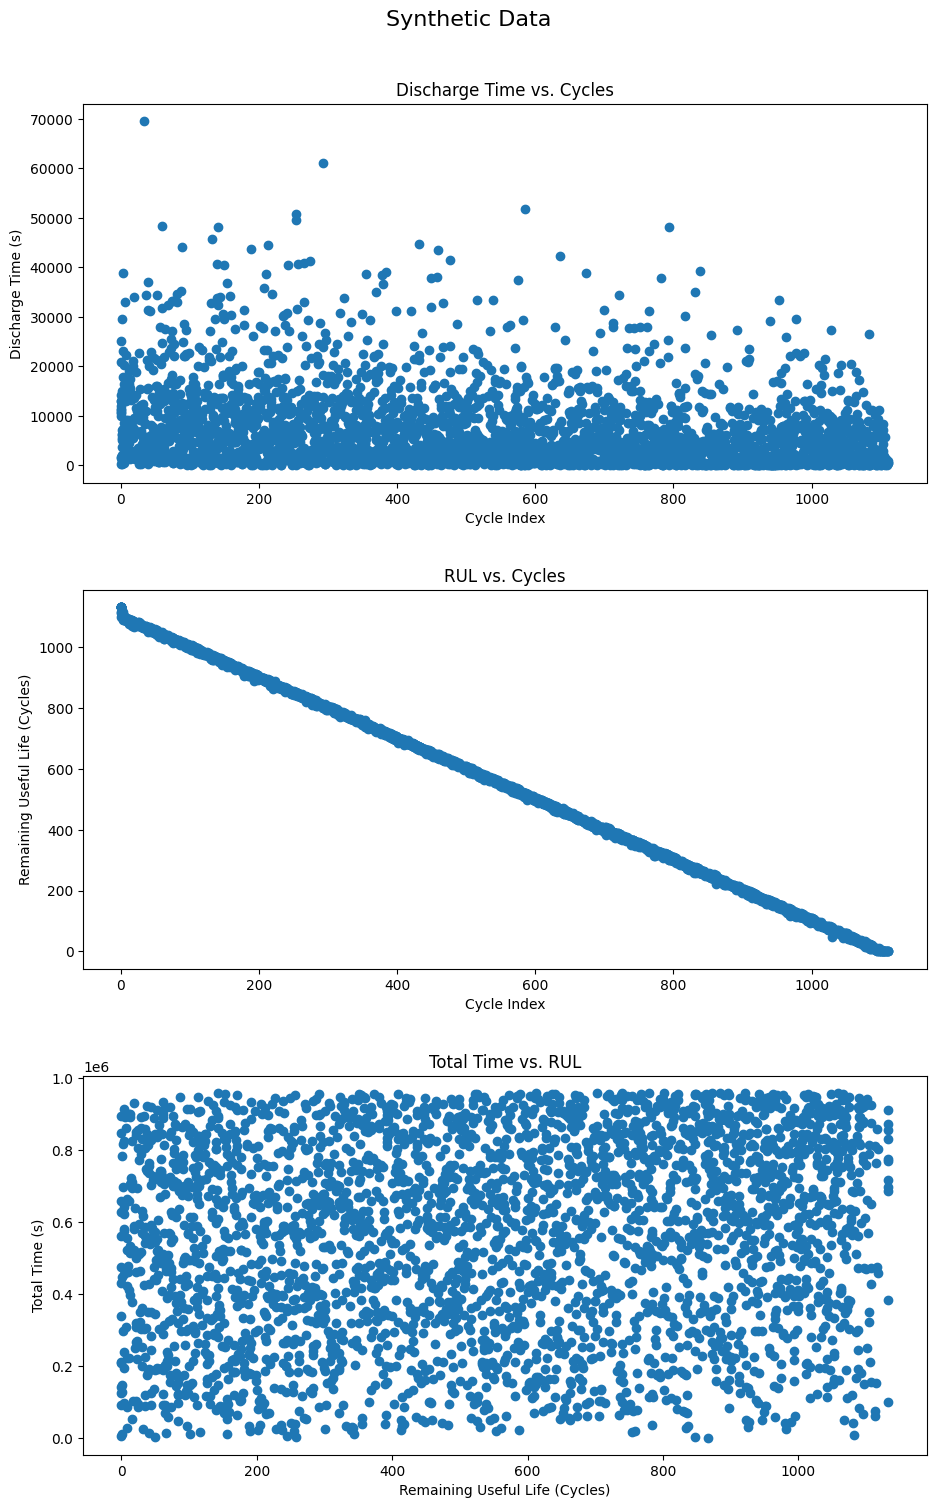

In [9]:
import pandas as pd

# Load the datasets
real_data = data
synthetic_data = new_data

import matplotlib.pyplot as plt

# Function to plot the graphs
def plot_data(data, title):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Discharge Time vs. Cycles
    axs[0].scatter(data['Cycle_Index'], data['Discharge Time (s)'])
    axs[0].set_title('Discharge Time vs. Cycles')
    axs[0].set_xlabel('Cycle Index')
    axs[0].set_ylabel('Discharge Time (s)')

    # RUL vs. Cycles
    axs[1].scatter(data['Cycle_Index'], data['RUL'])
    axs[1].set_title('RUL vs. Cycles')
    axs[1].set_xlabel('Cycle Index')
    axs[1].set_ylabel('Remaining Useful Life (Cycles)')

    # Total Time vs. RUL
    axs[2].scatter(data['RUL'], data['Total time (s)'])
    axs[2].set_title('Total Time vs. RUL')
    axs[2].set_xlabel('Remaining Useful Life (Cycles)')
    axs[2].set_ylabel('Total Time (s)')

    plt.tight_layout(pad=3.0)
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Plot for real data
plot_data(real_data, 'Real Data')

# Plot for synthetic data
plot_data(synthetic_data, 'Synthetic Data')



In [10]:
import numpy as np

# Calculate correlation matrices for both datasets
correlation_matrix_real = real_data.drop(['DeviceID'],axis = 1).iloc[:, 1:].corr()  # Exclude the Unnamed: 0 column
correlation_matrix_synthetic = synthetic_data.iloc[:, 1:].corr()

correlation_matrix_real_display = correlation_matrix_real
correlation_matrix_synthetic_display = correlation_matrix_synthetic

# Recalculate the Frobenius norm
frobenius_norm_recalculation = np.linalg.norm(correlation_matrix_real - correlation_matrix_synthetic)

(correlation_matrix_real_display, correlation_matrix_synthetic_display, frobenius_norm_recalculation)



(                           Cycle_Index  Discharge Time (s)  \
 Cycle_Index                   1.000000           -0.011925   
 Discharge Time (s)           -0.011925            1.000000   
 Decrement 3.6-3.4V (s)       -0.012090            0.444984   
 Max. Voltage Dischar. (V)    -0.782859            0.349161   
 Min. Voltage Charg. (V)       0.759850           -0.239410   
 Time at 4.15V (s)            -0.176486            0.776720   
 Time constant current (s)    -0.040622            0.912536   
 Charging time (s)            -0.018305            0.935544   
 Total time (s)               -0.026809            0.969673   
 RUL                          -0.999756            0.011957   
 
                            Decrement 3.6-3.4V (s)  Max. Voltage Dischar. (V)  \
 Cycle_Index                             -0.012090                  -0.782859   
 Discharge Time (s)                       0.444984                   0.349161   
 Decrement 3.6-3.4V (s)                   1.000000            

# Methodology:


Metadata Detection:
We began by examining our real battery dataset to understand its structure and properties. This step allowed us to capture key information about the dataset's columns, their types, and distributions.

Synthesizer Configuration:
With the metadata in hand, we configured a Gaussian Copula Synthesizer, a powerful tool for generating synthetic data while preserving statistical dependencies. We specified distributions for numerical columns like discharge time and total time, ensuring that the synthetic data reflects the variability observed in our real dataset.

Training the Synthesizer:
The synthesizer was then trained on our real battery data. This process involved teaching the synthesizer to understand the underlying statistical patterns and dependencies present in the data.

Generating Synthetic Data:
Using the trained synthesizer, we generated a synthetic dataset containing 100,000 rows. This synthetic data is a simulated representation of battery performance based on the statistical patterns learned from our real dataset.

Data Processing:
To ensure the quality and relevance of the synthetic data, we performed several post-processing steps. This included sorting the data by device ID and remaining useful life (RUL) and filtering out rows with positive decrement values, ensuring consistency with our real data.

Ensuring Data Consistency:
Finally, we took steps to ensure that the synthetic data maintains the same characteristics as our real dataset. We verified that RUL values decrease within each device ID group across cycles, maintaining the integrity of our analytical insights.

In [11]:
import pandas as pd

# Assuming 'synthetic_data' is your DataFrame
# Define the start date
start_date = pd.Timestamp('2023-01-01')

# Generate a date range
date_range = pd.date_range(start=start_date, periods=len(synthetic_data), freq='D')

# Add the date range as a new column to the DataFrame
synthetic_data['Timestamp'] = date_range
synthetic_data

,Unnamed: 0,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Total time (s),RUL,Timestamp
0,0,1.0,10756.940633,9249.348377,4.076,3.389,12569.637566,30710.530665,23150.336077,717225.820966,1133.0,2023-01-01
1,1,2.0,3763.105950,6616.144289,4.000,3.344,7309.680140,9904.157166,5056.186117,153961.554873,1115.0,2023-01-02
2,2,3.0,6128.217571,13711.900497,4.025,3.425,9678.459198,12841.436754,14964.972824,470725.227216,1100.0,2023-01-03
3,3,7.0,12968.343193,32800.264639,4.092,3.364,17000.589966,22550.219303,26573.512273,739053.009653,1089.0,2023-01-04
4,4,16.0,1663.215587,8888.168965,4.050,3.455,-113.584000,14267.120255,5520.662850,611740.881666,1078.0,2023-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
3164,3164,1085.0,12.584393,1904.722474,3.728,3.795,-113.584000,5.980000,5.980000,54082.369084,16.0,2031-08-31
3165,3165,1087.0,11087.673179,19448.481009,3.785,3.722,14181.676932,46439.461057,52041.341216,892080.962698,12.0,2031-09-01
3166,3166,1092.0,865.506131,7827.895092,3.828,3.802,-113.584000,5.980000,5.980000,623018.315853,4.0,2031-09-02
3167,3167,1094.0,7670.993080,3128.073875,3.820,3.641,9358.801026,47048.449541,60770.415297,446389.892770,1.0,2031-09-03


# Machine Learning

In [12]:
new_data = new_data.drop(['Timestamp'],axis=1)

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
# Compute the absolute value of correlation with the target
correlation_matrix = new_data.corr().abs()
correlation_with_target = correlation_matrix['RUL']

# Define a correlation threshold
threshold = 0.3  # You can adjust this value

# Find columns with correlation less than the threshold
columns_to_drop = correlation_with_target[correlation_with_target < threshold].index.tolist()

# Drop these columns from the features DataFrame
features = new_data.drop(columns=columns_to_drop + ['RUL'])
features_to_scale = new_data.columns.difference(['Cycle_Index', 'RUL'])
scaler = MinMaxScaler()
new_data[features_to_scale] = scaler.fit_transform(new_data[features_to_scale])

# Now proceed with the rest of your pipeline as before
look_back = 5
target = new_data['RUL']

def create_sequences(features, target, look_back=1):
    X, y = [], []
    for i in range(len(features) - look_back):
        x_sequence = features.iloc[i:(i + look_back)].values
        y_sequence = target.iloc[i + look_back]
        X.append(x_sequence)
        y.append(y_sequence)
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, look_back)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((2531, 5, 3), (633, 5, 3))

In [14]:
!pip install scikeras

zsh:1: command not found: pip


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# List of hyperparameters to try
lstm_units_options = [20, 50, 100]
optimizer_lr_options = [0.001, 0.01, 0.1]
batch_size_options = [16, 32, 64]
epochs_options = [5, 10, 30]

# Record the best score and corresponding hyperparameters
best_score = np.inf
best_params = {}

for lstm_units in lstm_units_options:
    for optimizer_lr in optimizer_lr_options:
        for batch_size in batch_size_options:
            for epochs in epochs_options:
                # Create the model with the current set of hyperparameters
                model = Sequential([
                    LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
                    LSTM(lstm_units, return_sequences=False),
                    Dense(50, activation='relu'),
                    Dense(1)
                ])
                print(1)
                model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=optimizer_lr))

                # Fit the model
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

                # Evaluate the model
                val_loss = np.min(history.history['val_loss'])  # Get the best validation loss achieved

                # Update the best parameters if the current model is better
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {
                        'lstm_units': lstm_units,
                        'optimizer_lr': optimizer_lr,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }

# Print the best model's parameters and its score
print("Best Validation Loss: {:.4f}".format(best_score))
print("Best Parameters:")
print(best_params)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Best Validation Loss: 6689.5508
Best Parameters:
{'lstm_units': 50, 'optimizer_lr': 0.01, 'batch_size': 16, 'epochs': 30}


In [18]:
#model.get_params().keys()

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 401198.0625 - val_loss: 381475.1250
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 379838.9062 - val_loss: 342675.0625
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 350464.1562 - val_loss: 294914.5312
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 294862.2500 - val_loss: 243719.2188
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 233873.1719 - val_loss: 195358.6094
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184492.5469 - val_loss: 157047.0781
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148122.4531 - val_loss: 130787.6797
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124493.0312 - val_loss: 115798.4688
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110770.9609 - val_loss: 108682.5469
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105373.9453 - val_loss: 106387.7266
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_pred_lstm = lstm_model.predict(X_test)
n=len(X)
p=X.shape[1]
# Calculate metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
r2_adj_lstm = 1 - ((1-r2_lstm) * (n-1) / (n-p-1))  # Adjusted R² assuming p (number of features) is the number of inputs to the model

print(f"RMSE: {rmse_lstm}, MAE: {mae_lstm}, R²: {r2_lstm}, Adjusted R²: {r2_adj_lstm}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 85.40499393497447, MAE: 15.554181031141235, R²: 0.9308047894188476, Adjusted R²: 0.9306952339872752


In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Flatten the input data
X_train_flat = X_train.mean(axis=1)
X_test_flat = X_test.mean(axis=1)

# Define the model
xgb_model = XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Define a scorer, optional if you just want to use the default scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scorer, cv=3, verbose=2, n_jobs=-1)

# Perform the grid search
grid_result = grid_search.fit(X_train_flat, y_train)

# Best parameters and best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Optional: Extract results for further analysis
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best: -9708.894549 using {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
-46667.978527 (2092.837778) with: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
-46625.146148 (2079.957504) with: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
-46613.111311 (2068.289781) with: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
-24451.022588 (2441.513770) with: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
-24387.871091 (2433.478113) with: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
-24326.678295 (2408.898080) with: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, '

In [22]:
from xgboost import XGBRegressor

# Calculate the average of features across the time steps for each sequence
X_train_flat = X_train.mean(axis=1)
X_test_flat = X_test.mean(axis=1)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train_flat, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test_flat)

# Calculate RMSE, MAE, R², and adjusted R² for XGBoost model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
n, p = X_test_flat.shape[0], X_test_flat.shape[1]  # n is number of samples, p is number of features
r2_adj_xgb = 1 - ((1-r2_xgb) * (n-1) / (n-p-1))

print(f"RMSE: {rmse_xgb}, MAE: {mae_xgb}, R²: {r2_xgb}, Adjusted R²: {r2_adj_xgb}")


RMSE: 87.13293028357333, MAE: 24.759920030596884, R²: 0.9279765132623617, Adjusted R²: 0.9276329990171902


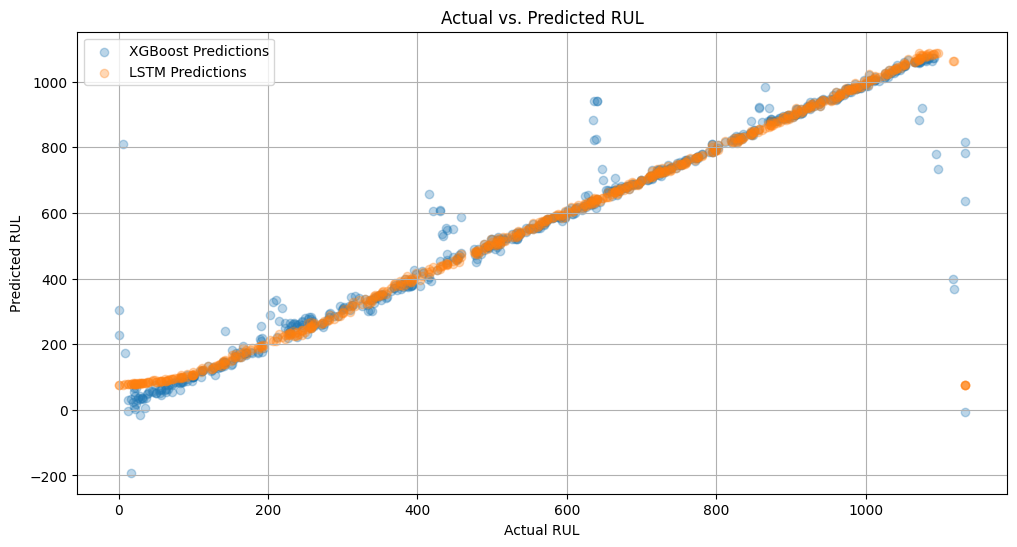

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, label='XGBoost Predictions')
plt.scatter(y_test, y_pred_lstm, alpha=0.3, label='LSTM Predictions')
plt.title('Actual vs. Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()


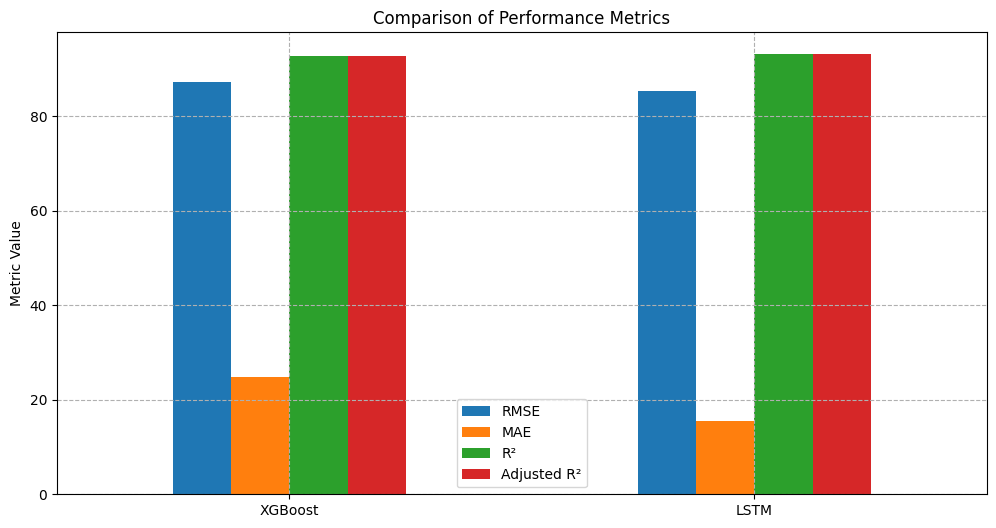

In [24]:
import numpy as np

# Assuming you have calculated these metrics already
metrics = {
    'RMSE': [rmse_xgb, rmse_lstm],
    'MAE': [mae_xgb, mae_lstm],
    'R²': [r2_xgb*100, r2_lstm*100],
    'Adjusted R²': [r2_adj_xgb*100, r2_adj_lstm*100]
}
metrics_df = pd.DataFrame(metrics, index=['XGBoost', 'LSTM'])

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Performance Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--')
plt.show()
